In [29]:
import featurization
import helpers
import model

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np

%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [3]:
from shapely.geometry import Polygon
import scipy.stats as scs

In [132]:
geodf = featurization.all_featurization("all-sc-bike-data-1101.csv")

Dropping 1 entries where end time was before start time


In [23]:
X = geodf[['day_of_week', 'time_of_day_start', 'ZONING', 'pop_density']]
X = pd.get_dummies(X, columns=['ZONING'], prefix='zone')
#X = pd.get_dummies(X, columns=['GEOID_Data'], prefix='blockgroup')
y = np.log(geodf['idle_time'].dt.seconds)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
X = geodf
y = geodf['idle_hours']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=1)

In [24]:
gbmodel = GradientBoostingRegressor()
gbmodel.fit(X_train1, y_train1)
print(gbmodel.score(X_train1, y_train1))
print(gbmodel.score(X_test1, y_test1))

0.2331832363421417
0.20510557183499378


In [62]:
y_pred = gbmodel.predict(X_test1)
y_pred = pd.Series(y_pred, index=y_test1.index)

Text(0, 0.5, 'gradient boost predicted idle times (log seconds)')

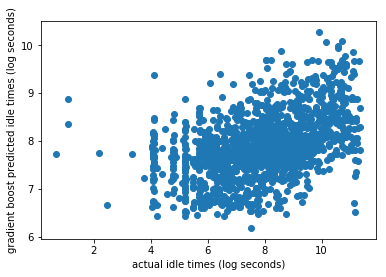

In [147]:
plt.scatter(y_test1, y_pred)
plt.xlabel('actual idle times (log seconds)')
plt.ylabel('gradient boost predicted idle times (log seconds)')

In [63]:
actual_top_10_gb = y_test1.transform(lambda x: x >= x.quantile(.90))
predicted_top_10_gb = pd.Series(y_pred).transform(lambda x: x >= x.quantile(.90))
(actual_top_10_gb == predicted_top_10_gb).mean()

0.8774647887323944

In [39]:
betas = model.get_updated_distributions(X_train2, X_test2)

In [41]:
result_df = pd.merge(pd.DataFrame(y_test2), betas, left_index=True, right_index=True)

In [44]:
rss = ((result_df['idle_hours'] - result_df['most_likely_beta']) ** 2).sum()
tss = ((result_df['idle_hours'] - result_df['idle_hours'].mean()) ** 2).sum()
r2 = 1 - (rss/tss)

In [45]:
r2

0.14972134750998867

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'exponential decay expected idle time (hours)')

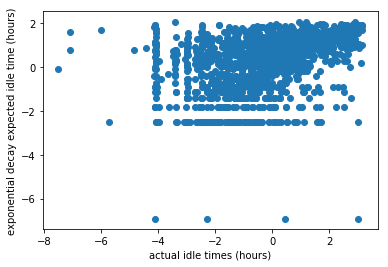

In [144]:
plt.scatter(np.log(result_df['idle_hours']), np.log(result_df['most_likely_beta']))
plt.xlabel('actual idle times (hours)')
plt.ylabel('exponential decay expected idle time (hours)')

In [46]:
actual_top_20 = result_df['idle_hours'].transform(lambda x: x >= x.quantile(.80))
predicted_top_20 = result_df['most_likely_beta'].transform(lambda x: x >= x.quantile(.80))

In [49]:
(actual_top_20 == predicted_top_20).mean()

0.7658227848101266

In [51]:
(1-predicted_top_20).mean()

0.7876230661040787

In [52]:
actual_top_10 = result_df['idle_hours'].transform(lambda x: x >= x.quantile(.90))
predicted_top_10 = result_df['most_likely_beta'].transform(lambda x: x >= x.quantile(.90))
(actual_top_10 == predicted_top_10).mean()

0.860056258790436

In [53]:
actual_top_5 = result_df['idle_hours'].transform(lambda x: x >= x.quantile(.95))
predicted_top_5 = result_df['most_likely_beta'].transform(lambda x: x >= x.quantile(.95))
(actual_top_5 == predicted_top_5).mean()

0.919831223628692

In [65]:
result_df['idle_hours'].mean()

2.5752250351617447

In [64]:
result_df[predicted_top_10]['idle_hours'].mean()

5.958600427350429

In [66]:
y_test1[predicted_top_10_gb].mean()

9.558612674326469

In [68]:
sum(predicted_top_10)

156

In [85]:
b1 = result_df['most_likely_beta'][10]

In [86]:
b1

0.24339393939393938

In [93]:
1 - scs.expon.cdf(0.5, scale=b1)

0.1281847279270416

In [94]:
def prob_a_bike_will_be_there_in_x_hours(x, beta):
    return (1 - scs.expon.cdf(x, scale=beta))

In [249]:
prob_outcome = [scs.expon(scale=np.e**y_pred.iloc[i]/3600).cdf(np.e**y_test1.iloc[i]/3600) for i in range(len(y_pred))]
prob_outcome = np.array(prob_outcome)

In [250]:
pspace = np.linspace(0,1)
cal = [(prob_outcome<p).sum()/len(prob_outcome) for p in pspace]

Text(0, 0.5, 'Fraction of idles with this outcome')

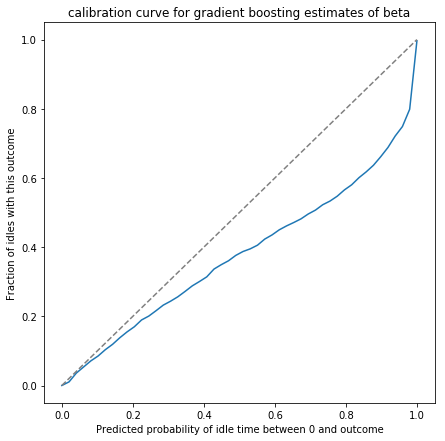

In [251]:
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(pspace, cal)
ax.plot([0,1],[0,1], c="grey", linestyle='dashed')
ax.set_title("calibration curve for gradient boosting estimates of beta")
ax.set_xlabel("Predicted probability of idle time between 0 and outcome")
ax.set_ylabel("Fraction of idles with this outcome")

In [227]:
prob_outcome = [scs.expon(scale=result_df['most_likely_beta'].iloc[i]).cdf(y_test2.iloc[i]) for i in range(len(y_test2))]

In [229]:
prob_outcome = np.array(prob_outcome)

In [230]:
(prob_outcome < 0.05).sum() / len(prob_outcome)

0.1288732394366197

In [231]:
pspace = np.linspace(0,1)
cal = [(prob_outcome<p).sum()/len(prob_outcome) for p in pspace]

Text(0, 0.5, 'Fraction of idles with this outcome')

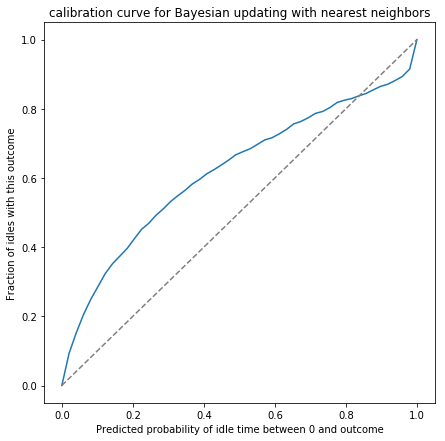

In [235]:
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(pspace, cal)
ax.plot([0,1],[0,1], c="grey", linestyle='dashed')
ax.set_title("calibration curve for Bayesian updating with nearest neighbors")
ax.set_xlabel("Predicted probability of idle time between 0 and outcome")
ax.set_ylabel("Fraction of idles with this outcome")

In [233]:
beta = y_train2.mean()
prob_outcome = [scs.expon(scale=beta).cdf(y_test2.iloc[i]) for i in range(len(y_test2))]
prob_outcome = np.array(prob_outcome)
pspace = np.linspace(0,1)
cal = [(prob_outcome<p).sum()/len(prob_outcome) for p in pspace]

Text(0, 0.5, 'Fraction of idles with this outcome')

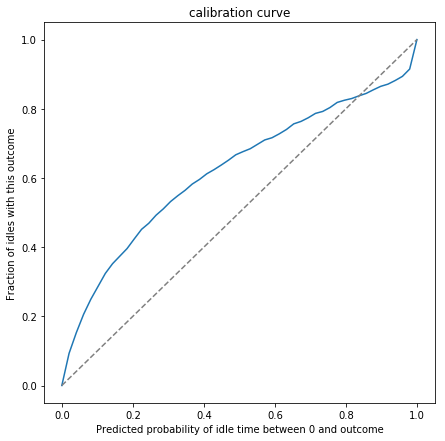

In [234]:
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(pspace, cal)
ax.plot([0,1],[0,1], c="grey", linestyle='dashed')
ax.set_title("calibration curve")
ax.set_xlabel("Predicted probability of idle time between 0 and outcome")
ax.set_ylabel("Fraction of idles with this outcome")

In [130]:
geodf.idle_hours.describe()

count    7098.000000
mean        2.521644
std         4.212177
min         0.000000
25%         0.218125
50%         0.760694
75%         2.503819
max        23.905278
Name: idle_hours, dtype: float64

In [205]:
import datetime

In [206]:
datetime.date(2018,10,25)

datetime.date(2018, 10, 25)

In [98]:
one_bike = geodf.iloc[5]

In [99]:
one_point = one_bike['geolocation']
buff = geopandas.GeoSeries(one_point).buffer(1000)
points_in_buff = geodf[geodf.intersects(buff.iloc[0])]

In [210]:
points_in_buff.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 184 entries, 58 to 10639
Data columns (total 24 columns):
bike_id                      184 non-null object
lat                          184 non-null float64
lon                          184 non-null float64
idle_time                    184 non-null timedelta64[ns]
batt_start                   184 non-null int64
batt_end                     184 non-null int64
utc_time_start               184 non-null datetime64[ns, UTC]
utc_time_end                 184 non-null datetime64[ns, UTC]
idle_hours                   184 non-null float64
local_time_start             184 non-null datetime64[ns, America/Los_Angeles]
local_time_end               184 non-null datetime64[ns, America/Los_Angeles]
day_of_week                  184 non-null int64
time_of_day_start            184 non-null int64
time_of_day_end              184 non-null int64
gets_pickedup_charged        184 non-null bool
just_got_charged             184 non-null bool
gets_pickedup

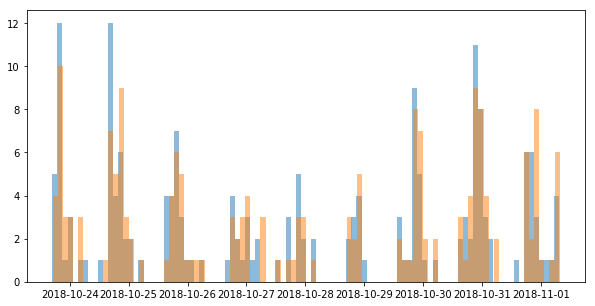

In [162]:
plt.figure(figsize=(10,5))
plt.hist(points_in_buff.local_time_start, bins = 100, alpha=0.5)
plt.hist(points_in_buff.local_time_end, bins = 100, alpha=0.5)
plt.show()

In [225]:
one_day = points_in_buff[(points_in_buff['local_time_start'].dt.tz_localize(None) <'2018-10-25') & (points_in_buff['local_time_start'].dt.tz_localize(None) >'2018-10-23')]

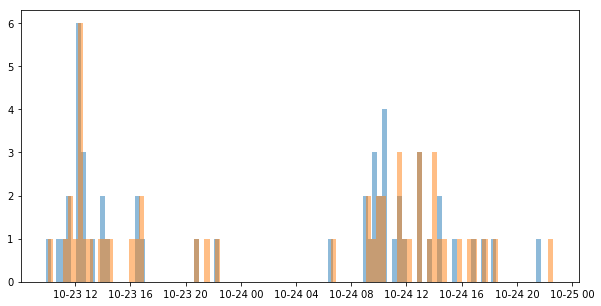

In [226]:
plt.figure(figsize=(10,5))
plt.hist(one_day.local_time_start.dt.tz_localize(None), bins = 100, alpha=0.5)
plt.hist(one_day.local_time_end.dt.tz_localize(None), bins = 100, alpha=0.5)
plt.show()

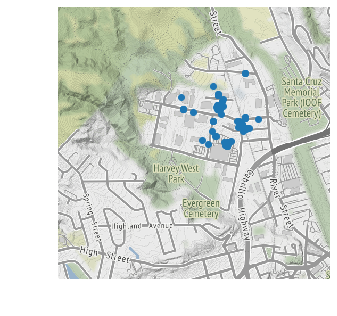

In [222]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
helpers.map_bikes (ax, points_in_buff)

In [221]:
one_day.local_time_start

58      2018-10-23 12:26:39-07:00
59      2018-10-23 13:28:01-07:00
256     2018-10-23 16:27:46-07:00
254     2018-10-23 16:31:47-07:00
226     2018-10-24 09:06:43-07:00
218     2018-10-24 09:18:50-07:00
221     2018-10-24 09:37:02-07:00
244     2018-10-24 09:58:09-07:00
234     2018-10-24 10:21:17-07:00
995     2018-10-24 14:22:21-07:00
1278    2018-10-24 12:54:19-07:00
1594    2018-10-24 11:43:21-07:00
1748    2018-10-24 16:45:00-07:00
1891    2018-10-23 12:06:35-07:00
1937    2018-10-24 09:39:02-07:00
1930    2018-10-24 10:16:16-07:00
2857    2018-10-24 09:00:36-07:00
3302    2018-10-24 10:17:15-07:00
3799    2018-10-23 20:41:58-07:00
3941    2018-10-23 12:21:39-07:00
4072    2018-10-23 12:12:36-07:00
4404    2018-10-24 11:34:15-07:00
4802    2018-10-23 12:15:37-07:00
5101    2018-10-24 12:52:14-07:00
5219    2018-10-24 17:43:15-07:00
5398    2018-10-24 10:19:16-07:00
5432    2018-10-23 22:23:14-07:00
5808    2018-10-24 13:36:04-07:00
6174    2018-10-23 12:19:38-07:00
6524    2018-1

In [109]:
start_time = geodf.local_time_start.min()

In [103]:
time_to_arrival = geodf.local_time_start - start_time

In [127]:
time_to_arrival_hours = time_to_arrival.dt.total_seconds()/3600

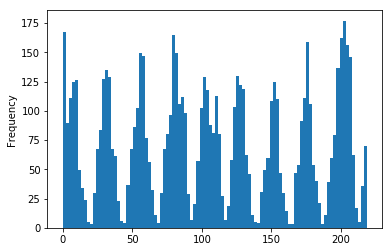

In [128]:
time_to_arrival_hours.plot.hist(bins=100)

In [116]:
time_to_arrival.describe()

count                      7098
mean     4 days 11:27:33.507044
std      2 days 16:33:19.458760
min             0 days 00:00:00
25%             2 days 06:56:43
50%             4 days 07:51:43
75%      7 days 01:10:57.250000
max             9 days 02:30:56
Name: local_time_start, dtype: object

In [117]:
time_to_arrival_hours.describe()

count    7098.000000
mean        8.903094
std         5.324146
min         0.000000
25%         5.098819
50%         8.347778
75%        12.042222
max        23.998889
Name: local_time_start, dtype: float64